In [ ]:
# default_exp score

# Score

> Functions related to the score

This notebook contains all functions related to the scoring of peptide-spectrum-matches (PSMS).

Current ToDo here:

- Most of the functions are not very well described yet
- Introductory text to give an overview as well as the relevant papers would be nice

## Q-Values


In [ ]:
#export
from numba import njit
import numpy as np
import pandas as pd

def filter_seq(df):
    """
    Filter df by sequence

    """
    df["rank_sequence"] = (
        df.groupby("sequence")["score"].rank("dense", ascending=False).astype("int")
    )
    df_filtered = df[df["rank_sequence"] == 1]

    return df_filtered


def filter_score(df):
    """
    Filter df by score
    TODO: PSMS could get the same score when having modifications. Only keep one

    """
    df["rank"] = df.groupby("query_idx")["score"].rank("dense", ascending=False).astype("int")

    df_filtered = df[df["rank"] == 1]
    # in case two hits have the same score and therfore rank only accept the first one
    df_filtered = df_filtered.drop_duplicates("query_idx")

    # TOD: this needs to be sorted out, for modifications -> What if we have MoxM -> oxMM, this will screw up with the filter sequence part
    return df_filtered

@njit
def get_q_values(fdr_values):
    """
    Calculate q values from fdr_values
    """
    q_values = np.zeros_like(fdr_values)
    min_q_value = np.max(fdr_values)
    for i in range(len(fdr_values) - 1, -1, -1):
        fdr = fdr_values[i]
        if fdr < min_q_value:
            min_q_value = fdr
        q_values[i] = min_q_value

    return q_values

## FDR

The employed FDR strategy is based on classical target-decoy competition approach. The FDR is approximated by dividing the number of decoy discoveries by the number of target discoveries at agiven score threshold ( #decoys / #targets ).

In [ ]:
#export
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def cut_fdr(df, fdr_level=0.01, plot=True, verbose=True):
    """
    Cuts a dataframe with a given fdr level

    Args:
        fdr_level: fdr level that should be used
        plot: flag to enable plot
        verbose: flag to enable printing of results

    Returns:
        cutoff: df with psms within fdr
        cutoff_value: numerical value of score cutoff

    Raises:

    """

    df["target"] = ~df["decoy"]

    df = df.sort_values(by=["score","decoy"], ascending=False)
    df = df.reset_index()

    df["target_cum"] = np.cumsum(df["target"])
    df["decoys_cum"] = np.cumsum(df["decoy"])

    df["fdr"] = df["decoys_cum"] / df["target_cum"]
    df["q_value"] = get_q_values(df["fdr"].values)

    last_q_value = df["q_value"].iloc[-1]
    first_q_value = df["q_value"].iloc[0]

    if last_q_value < fdr_level:
        if verbose:
            print('Last q_value {:.3f} of dataset is smaller than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = len(df)-1

    elif first_q_value > fdr_level:
        if verbose:
            print('First q_value {:.3f} of dataset is larger than fdr_level {:.3f}'.format(last_q_value, fdr_level))
        cutoff_index = 0

    else:
        cutoff_index = df[df["q_value"].gt(fdr_level)].index[0] - 1

    cutoff_value = df.loc[cutoff_index]["score"]
    cutoff = df[df["score"] >= cutoff_value]

    targets = df.loc[cutoff_index, "target_cum"]
    decoy = df.loc[cutoff_index, "decoys_cum"]

    fdr = df.loc[cutoff_index, "fdr"]

    if verbose:
        print(
            "{:,} target ({:,} decoy) of {} PSM. fdr {:.6f} for a cutoff of {:.2f} ".format(
                targets, decoy, len(df), fdr, cutoff_value
            )
        )

    if plot:
        import matplotlib.pyplot as plt
        import seaborn as sns
        plt.figure(figsize=(10, 5))
        plt.plot(df["score"], df["fdr"])
        plt.axhline(0.01, color="k", linestyle="--")

        plt.axvline(cutoff_value, color="r", linestyle="--")
        plt.title("fdr vs Cutoff value")
        plt.xlabel("Score")
        plt.ylabel("fdr")
        # plt.savefig('fdr.png')
        plt.show()

        bins = np.linspace(np.min(df["score"]), np.max(df["score"]), 100)
        plt.figure(figsize=(10, 5))
        sns.distplot(df[df["decoy"]]["score"].values, label="decoy", bins=bins)
        sns.distplot(df[~df["decoy"]]["score"].values, label="target", bins=bins)
        plt.xlabel("Score")
        plt.ylabel("Frequency")
        plt.title("Score vs Class")
        plt.legend()
        plt.show()

    cutoff = cutoff.reset_index(drop=True)
    return cutoff_value, cutoff

In [ ]:
#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#hide
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def simulateTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5):
    decoys = np.random.normal(loc=0.0, scale=stdev, size=n)
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=int(np.round(n*pi0)))
    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=int(np.round(n*(1-pi0))))
    
    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(true_targets)),np.repeat('FT',len(false_targets))),np.repeat('D',len(decoys))),
        'decoy':np.append(np.repeat(False,len(true_targets)+len(false_targets)), np.repeat(True,len(decoys))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,n),np.arange(0,n)),
        'protein':np.append(np.arange(0,n),np.arange(0,n))})
    
    return df

def simulateProteinLevelTargetDecoyScores(n, target_mu=4.0, stdev=1.0, pi0=0.5, plot=True):
    idx = np.arange(0,n)

    protein_size = np.random.poisson(lam=3.0, size=n) + 1
    
    if plot:
        plt.hist(protein_size)
        plt.title("Number of peptides per protein")
        plt.xlabel("Number of peptides per protein")
        plt.ylabel("Count")
        plt.show()

    TT_protein_size = protein_size[idx[0:int(np.round(1-(n*pi0)))]]
    FT_protein_size = protein_size[idx[int(np.round(1-(n*pi0))):n]]
    D_protein_size = protein_size

    true_targets = np.random.normal(loc=target_mu, scale=stdev, size=sum(TT_protein_size))
    false_targets = np.random.normal(loc=0.0, scale=stdev, size=sum(FT_protein_size))
    decoys = np.random.normal(loc=0.0, scale=stdev, size=sum(D_protein_size))

    D_proteins = np.repeat(idx,D_protein_size)
    TT_proteins = np.repeat(idx[0:int(np.round(1-(n*pi0)))],TT_protein_size)
    FT_proteins = np.repeat(idx[int(np.round(1-(n*pi0))):n],FT_protein_size)

    df = pd.DataFrame({
        'TD':np.append(np.append(np.repeat('TT',len(TT_proteins)),np.repeat('FT',len(FT_proteins))),np.repeat('D',len(D_proteins))),
        'decoy':np.append(np.repeat(False,len(TT_proteins)+len(FT_proteins)), np.repeat(True,len(D_proteins))),
        'score':np.append(np.append(true_targets,false_targets),decoys),
        'sequence':np.append(np.arange(0,sum(protein_size)),np.arange(0,sum(protein_size))),
        'protein':np.append(np.append(TT_proteins,FT_proteins),D_proteins)})

    return df

def plot_score_hist(df, analyte_level='sequence'):
    
    if analyte_level=='protein':
        df = df.sort_values(by=['protein','score'], ascending=False)
        df = df.drop_duplicates(subset='protein', keep="first")
    
    decoys=df[df.decoy].score.values
    false_targets= df[df.TD == 'FT'].score.values
    true_targets= df[df.TD == 'TT'].score.values
    
    minS = int(np.round(np.min(np.append(decoys, np.append(false_targets, true_targets)))))
    maxS = int(np.round(np.max(np.append(decoys, np.append(false_targets, true_targets)))))
    
    plt.hist(false_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='false targets')
    plt.hist(true_targets, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='mid', label='true targets')
    plt.hist(decoys, rwidth=.4, bins=range(minS,maxS), range=[minS,maxS], align='left', label='decoys')
    plt.legend(loc='best')
    plt.title("score histogram")
    plt.xlabel("score")
    plt.ylabel("count")
    plt.xlim(-5,10)
    plt.show()

def score_TDcompetition(df):
    td_dataframe = pd.DataFrame({'T':df[~df.decoy].score.values, 'D':df[df.decoy].score.values, 'label':df[~df.decoy].TD.values})
    td_dataframe['win'] = td_dataframe.apply(lambda x: 'T' if x['T'] > x['D'] else 'D', axis = 1)

    target_in = np.where(td_dataframe.win=='T')
    decoy_in = np.where(td_dataframe.win=='D')

    T_df = df[(~df.decoy) & (np.isin(df.sequence, target_in))]
    D_df = df[(df.decoy) & (np.isin(df.sequence, decoy_in))]
    
    df = T_df.append(D_df)
    
    return df


def get_simulated_stat_rates(df, TDcompetition = False, analyte_level='sequence', df_ini = None):
    alpha = np.arange(0.002,1,0.002)
    stat_rates = pd.DataFrame(columns=['alpha','TP','FP','TN','FN','TPR','FPR','FDR','FNR','ACC'])

    if analyte_level=='protein':
        df = df.drop_duplicates(subset='protein', keep="first")
        
    for idx in range(len(alpha)):
        sig = df[df.q_value <= alpha[idx]]
        not_sig = df[df.q_value > alpha[idx]]

        TP = len(sig[sig.TD == 'TT'][analyte_level].unique())
        FP = len(sig[sig.TD == 'FT'][analyte_level].unique())
        TN = len(not_sig[not_sig.TD == 'FT'][analyte_level].unique())
        FN = len(not_sig[not_sig.TD == 'TT'][analyte_level].unique())
        
        if TDcompetition:
            TN = TN + (len(df_ini[df_ini.TD == 'FT'][analyte_level].unique()) - len(df[df.TD == 'FT'][analyte_level].unique()))
            FN = FN + (len(df_ini[df_ini.TD == 'TT'][analyte_level].unique()) - len(df[df.TD == 'TT'][analyte_level].unique()))


        TPR = TP/(TP+FN) 
        FPR = FP/(FP+TN) 
        if (FP+TP)==0:
            FDR = 0
        else:
            FDR = FP/(FP+TP)
        FNR = FN/(FN+TP)

        ACC = (TP+TN)/(TP+TN+FP+FN)

        stat_rates.loc[idx] = [alpha[idx], TP, FP, TN, FN, TPR, FPR, FDR, FNR, ACC] 
    
    border = 0.1
    
    plt.plot([-1,2], [-1,2], 'k-')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("decoy vs. true FDR")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.plot([-1,1], [-1,1], 'k-')
    plt.scatter(stat_rates.alpha, stat_rates.FDR)
    plt.ylim(0-(0.01),0.1+(0.01))
    plt.xlim(0-(0.01),0.1+(0.01))
    plt.title("decoy vs. true FDR (zoom)")
    plt.xlabel("decoy FDR")
    plt.ylabel("true FDR")
    plt.show()
    
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-border,1+border)
    plt.title("ROC curve")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    plt.scatter(stat_rates.FPR, stat_rates.TPR)
    plt.ylim(0-border,1+border)
    plt.xlim(0-0.01,0.1+0.01)
    plt.title("ROC curve (zoom)")
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.show()
    
    return stat_rates

In [ ]:
#hide
TD = simulateTargetDecoyScores(n=50000, pi0=0.8, target_mu=3.5)
TDC = score_TDcompetition(TD)

Simulation of random scores for 50'000 measurements (corresponding to spectra). Simulated are decoys, true targets and false targets. We assume a false traget raio (pi0) of 0.8 and a mean score difference of 3.5.

Simulated score distribution for a separate target and decoy database search:

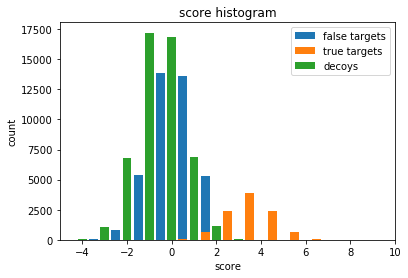

In [ ]:
#hide
plot_score_hist(TD, analyte_level='sequence')

Simulated score distribution for a corresponding concatinated target-decoy database search with target-decoy-competition:

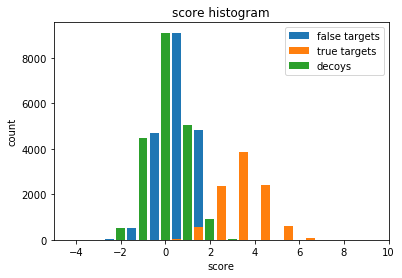

In [ ]:
#hide
plot_score_hist(TDC, analyte_level='sequence')

Application of the `cut_fdr` function to the simulated target-decoy competition dataset saved in `TDC`:

7,343 target (73 decoy) of 50000 PSM. fdr 0.009941 for a cutoff of 2.91 


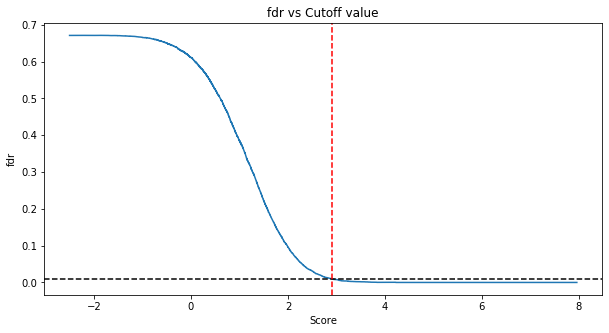

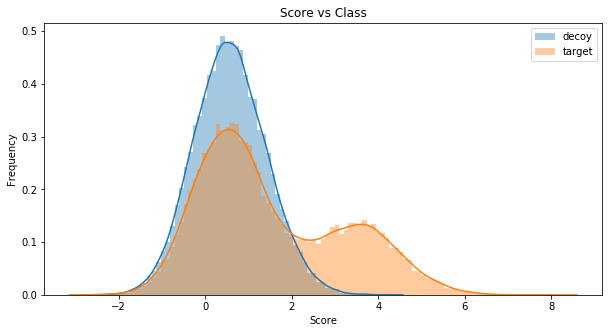

In [ ]:
cval, cut_TDC = cut_fdr(TDC, fdr_level=0.01)

Evaluation of the FDR estimated by the target-decoy approach versus the true FDR confirms accurate, slightly conservative FDR estimation by our approach:

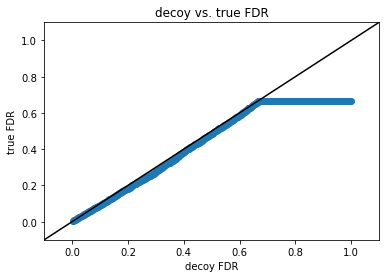

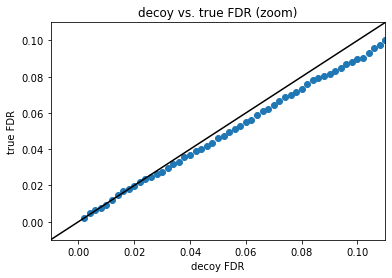

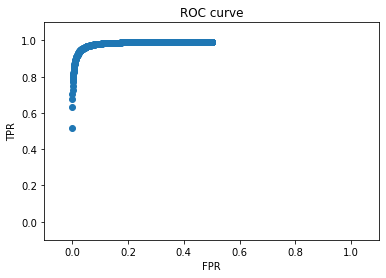

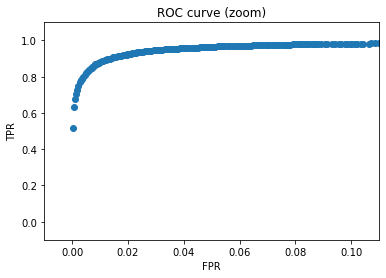

In [ ]:
# hide
cval_, cut_TDC_ = cut_fdr(TDC, fdr_level=100, plot=False, verbose=False)
stat = get_simulated_stat_rates(cut_TDC_, TDcompetition = True, analyte_level='sequence', df_ini = TD)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Global FDR

The global FDR model is based on the concept of selecting the best scoring analyte across the dataset and estimating the FDR by target-decoy competition. This function is also used for protein FDR estimation of a single run based on selecting the highest scoring peptided matching to the protein.

In [ ]:
#export

def cut_global_fdr(data, analyte_level='sequence', fdr_level=0.01, plot=True, verbose=True, **kwargs):
    """
    Function to estimate and filter by global peptide or protein fdr

    """
    data_sub = data[[analyte_level,'score','decoy']]
    data_sub_unique = data_sub.groupby([analyte_level,'decoy'], as_index=False).agg({"score": "max"})
    #print(data_sub_unique)

    if analyte_level=='sequence':
        agg_score = data_sub_unique.groupby([analyte_level,'decoy'])['score'].max().reset_index()
    elif analyte_level=='protein':
        agg_score = data_sub_unique.groupby([analyte_level,'decoy'])['score'].sum().reset_index()
    else:
        raise Exception('analyte_level should be either sequence or protein. The selected analyte_level was: {}'.format(analyte_level))

    agg_cval, agg_cutoff = cut_fdr(agg_score, fdr_level=fdr_level, plot=plot, verbose=verbose)
    #print(agg_cval)
    agg_report = pd.merge(data,
                          agg_cutoff,
                          how = 'inner',
                          on = [analyte_level,'decoy'],
                          suffixes=('', '_'+analyte_level),
                          validate="many_to_one")
    return agg_report

Similar to the sequence level simulations we can simulatae score distributions for peptides beloning to proteins. In our simulation we assumed a poisson distribution for the number of peptides for each protein centered at 4 peptides. 

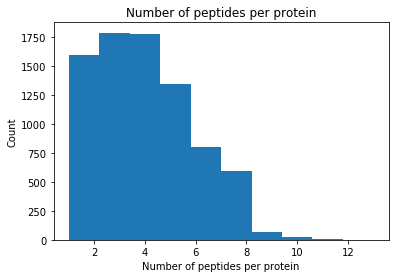

In [ ]:
#hide
TD_prot = simulateProteinLevelTargetDecoyScores(n=8000, pi0=0.8, target_mu=3.5)
#plot_score_hist(TD_prot, analyte_level='sequence')
#plot_score_hist(TD_prot, analyte_level='protein')
TDC_prot = score_TDcompetition(TD_prot)
#plot_score_hist(TDC_prot, analyte_level='sequence')
#plot_score_hist(TDC_prot, analyte_level='protein')

Application of the `cut_global_fdr` function to the simulated protein-level target-decoy competition dataset saved in `TDC_prot`:

1,506 target (15 decoy) of 13012 PSM. fdr 0.009960 for a cutoff of 3.22 


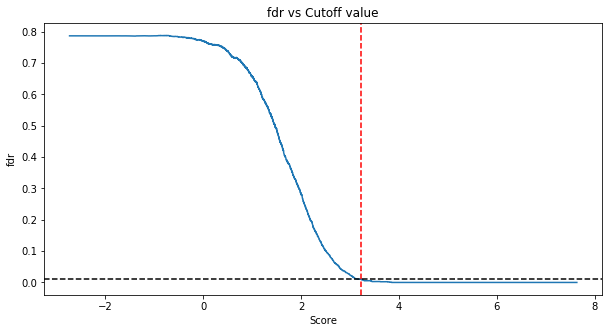

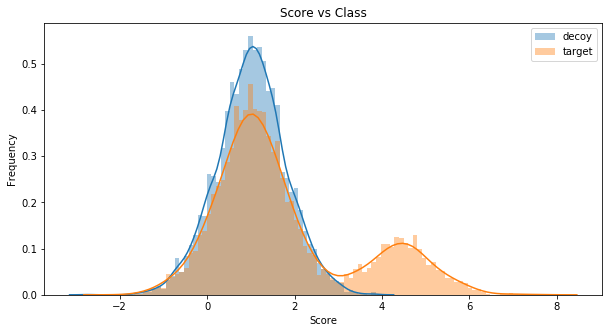

In [ ]:
cut_TDC_prot = cut_global_fdr(TDC_prot, fdr_level=0.01, analyte_level='protein')

Evaluation of the protein-level FDR estimated by the target-decoy approach versus the true FDR confirms accurate FDR estimation by our approach:

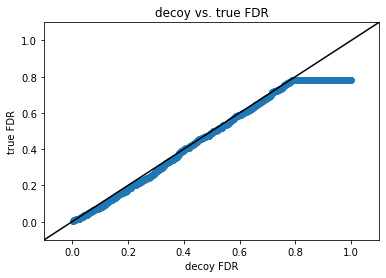

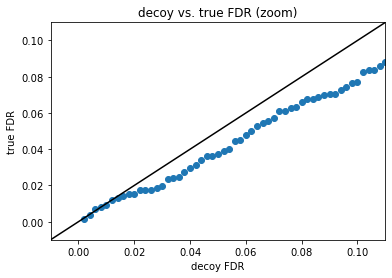

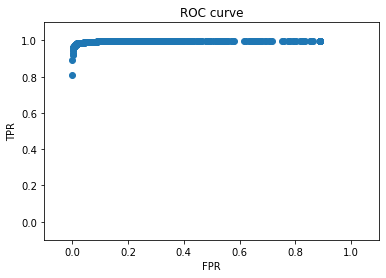

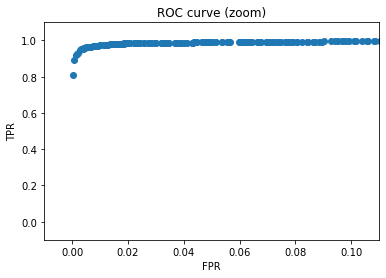

In [ ]:
#hide
cut_TDC_prot_ = cut_global_fdr(TDC_prot, fdr_level=100, analyte_level='protein', plot=False, verbose=False)
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='protein', df_ini = TD_prot)

Investigating the peptide-level statistics after protein-level FDR filtering shows a conservative pattern.

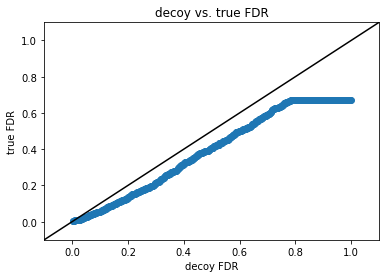

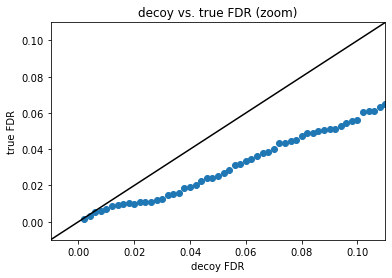

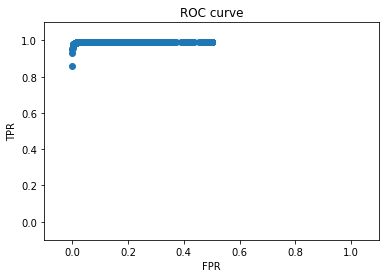

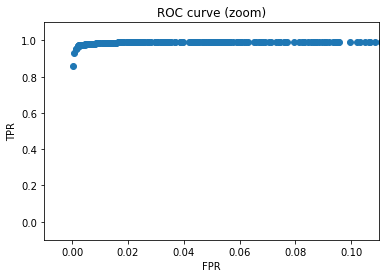

In [ ]:
#hide
stat_prot = get_simulated_stat_rates(cut_TDC_prot_, TDcompetition = True, analyte_level='sequence', df_ini = TD_prot)

Please be aware that the shown simulations are not an accurate model for PSMS scoring and they were designed only for illustrative purposes and to test the implemeted functions. 

## Scoring

In [ ]:
#export

import networkx as nx

def get_x_tandem_score(df):
    df['b_hits_int'] = df['b_hits'].astype('int')
    df['y_hits_int'] = df['y_hits'].astype('int')

    df['b_hits_fac'] = df['b_hits_int'].apply(lambda x: np.math.factorial(x))
    df['y_hits_fac'] = df['y_hits_int'].apply(lambda x: np.math.factorial(x))

    df['x_tandem'] = df['matched_int']*df['b_hits_fac']*df['y_hits_fac']
    df['x_tandem'] = df['x_tandem'].apply(lambda x: np.log(x))

    return df.x_tandem.values

def score_x_tandem(df, fdr_level = 0.01, plot = True, verbose=True, **kwargs):
    df['score'] = get_x_tandem_score(df)
    df['decoy'] = df['sequence'].str[-1].str.islower()

    df = filter_score(df)
    cval, cutoff = cut_fdr(df, fdr_level, plot, verbose)

    return cutoff



### Machine learning based scoring

The score_RF function trains a random forest classifier to score psms.

In [ ]:
#export

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt
import seaborn as sns


def score_RF(df, 
             features = ['y_hits','b_hits','matched_int',
                         'delta_m_ppm','abs_delta_m_ppm',
                         'charge_2.0','charge_3.0','charge_4.0','charge_5.0',
                         'nAA','nMissed','lnSequence','xTandem'],
             fdr_level = 0.01,
             ini_score = 'y_hits',
             n_iterations = 5,  
             n_train = 5000,
             max_depth = [5,20,50],
             max_leaf_nodes = [20,50, 100],
             plot = True, 
             verbose = True, 
             **kwargs):
    
    # Setup ML pipeline
    scaler = StandardScaler()
    rfc = RandomForestClassifier(class_weight={False:1,True:5}, random_state=22)
    ## Initiate scaling + classification pipeline
    pipeline = Pipeline([('scaler', scaler), ('clf', rfc)]) 
    parameters = {'clf__max_depth':(max_depth), 'clf__max_leaf_nodes': (max_leaf_nodes)}
    ## Setup grid search framework for parameter selection and internal cross validation
    cv = GridSearchCV(pipeline, param_grid=parameters, cv=3) # Create grid search for hyperparameter optimization of the pipeline
    
    # Append extra features 
    # @ToDo only do so if these features are requested in the input
    df['abs_delta_m_ppm'] = np.abs(df['delta_m_ppm'])
    df['nakedSequence'] = df['sequence'].str.replace('[a-z]|_', '')
    df['nAA']= df['nakedSequence'].str.len() 
    df['nMissed'] = df['sequence'].str.count('K') + df['sequence'].str.count('R') - 1
    df = pd.get_dummies(df, columns=['charge'])
    count_seq = df.groupby('sequence')['sequence'].count()
    df['lnSequence'] = np.log(count_seq[df['sequence']].values)
    df['xTandem'] = get_x_tandem_score(df)
    
    # Prepare target and decoy df
    df['decoy'] = df['sequence'].str[-1].str.islower()
    df['score'] = df[ini_score]
    dfT = df[~df.decoy]
    dfD = df[df.decoy]

    for i in range(0,n_iterations):
        if (i == 0):
            df_prescore = dfT.append(dfD)
        else:
            df_prescore["score"] = cv.predict_proba(df_prescore[features])

        df_scored = filter_score(df_prescore)
        df_scored = filter_seq(df_scored)
        scored = cut_fdr(df_scored, fdr_level, plot=False, verbose=False)[1]
        highT = scored[scored.decoy==False]
        dfT_high = dfT[dfT['query_idx'].isin(highT.query_idx)]
        df_training = dfT_high.sample(n=n_train,random_state=22).append(dfD.sample(n=n_train,random_state=22))

        X = df_training[features]

        y = df_training['decoy']
        X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=41, stratify=y.values)

        cv.fit(X_train,y_train)
        if verbose:
            print('Best parameters for iteration {} were {}'.format(i, cv.best_params_))
            print('Best test score was {}'.format(cv.score(X_test, y_test)))

    if plot:
        feature_importances=cv.best_estimator_.named_steps['clf'].feature_importances_
        indices = np.argsort(feature_importances)[::-1][:40]
        g = sns.barplot(y=X.columns[indices][:40],x = feature_importances[indices][:40] , orient='h', palette='RdBu')
        g.set_xlabel("Relative importance",fontsize=12)
        g.set_ylabel("Features",fontsize=12)
        g.tick_params(labelsize=9)
        g.set_title("Feature importance")
        plt.show()

    df_new = df.copy()
    df_new['score'] = cv.predict_proba(df_new[features])[:,0]
    df_new = filter_score(df_new)
    df_new = filter_seq(df_new)
    cval, cutoff = cut_fdr(df_new, fdr_level, plot, verbose)
    
    return cutoff

## Protein grouping

In [ ]:
#export

def get_protein_groups(data, pept_dict, fasta_dict, callback = None, **kwargs):
    """
    Function to perform protein grouping by razor approach
    ToDo: implement callback for solving
    """
    G=nx.Graph()

    found_proteins = {}

    for i in range(len(data)):
        line = data.iloc[i]
        seq = line['sequence']
        score = line['score']
        if seq in pept_dict:
            proteins = pept_dict[seq]
            if len(proteins) > 1:
                for protein in proteins:
                    G.add_edge(i, str(protein), score=score)
            else: #if there is only one PSM just add to this protein
                if proteins[0] in found_proteins.keys():
                    found_proteins[proteins[0]] = found_proteins[proteins[0]] + [i]
                else:
                    found_proteins[proteins[0]] = [i]

        if callback:
            callback((i+1)/len(data))

    print('A total of {:,} proteins with unique PSMs found'.format(len(found_proteins)))

    connected_groups = np.array([list(c) for c in sorted(nx.connected_components(G), key=len, reverse=True)])
    n_groups = len(connected_groups)
    print('A total of {} ambigious proteins'.format(len(connected_groups)))

    #Solving with razor:
    found_proteins_razor = {}
    for a in connected_groups:
        H = G.subgraph(a)

        nodes = list(np.array(a)[np.array(list(isinstance(i, str) for i in a))])

        removed = []


        while len(nodes) > 0:

            neighbors_list = []

            for node in nodes:
                neighbors = list(H.neighbors(node))
                n_neigbhors = len(neighbors)

                if node in G:
                    if node in found_proteins.keys():
                        n_neigbhors+= len(found_proteins[node])

                neighbors_list.append((n_neigbhors, node, neighbors))

            neighbors_list.sort()

            #Remove the last entry:

            count, node, psms = neighbors_list[-1]

            nodes.remove(node)

            psms = [_ for _ in psms if _ not in removed]

            removed+= psms

            found_proteins_razor[node] = psms

    #Put back in Df
    report = data.copy()
    report['protein'] = ''
    report['protein_group'] = ''

    for protein in found_proteins.keys():
        indexes = found_proteins[protein]
        report.loc[indexes, 'protein'] = fasta_dict[protein]['name']
        report.loc[indexes, 'protein_group'] = fasta_dict[protein]['name']

    report['razor'] = False
    for protein in found_proteins_razor.keys():
        indexes = found_proteins_razor[protein]
        report.loc[indexes, 'protein'] = fasta_dict[int(protein)]['name']
        report.loc[indexes, 'razor'] = True

    for a in connected_groups:
        protein_group = list(np.array(a)[np.array(list(isinstance(i, str) for i in a))])
        psms = [i for i in a if i not in protein_group]
        report.loc[psms, 'protein_group'] = ','.join([fasta_dict[int(_)]['name'] for _ in protein_groups])

    return report

def perform_protein_grouping(data, pept_dict, fasta_dict, **kwargs):
    """
    Wrapper function to perform protein grouping by razor approach

    """
    data_sub = data[['sequence','score','decoy']]
    data_sub_unique = data_sub.groupby(['sequence','decoy'], as_index=False).agg({"score": "max"})

    targets = data_sub_unique[data_sub_unique.decoy == False]
    targets = targets.reset_index(drop=True)
    protein_targets = get_protein_groups(targets, pept_dict, fasta_dict, **kwargs)

    decoys = data_sub_unique[data_sub_unique.decoy == True]
    decoys = decoys.reset_index(drop=True)
    protein_decoys = get_protein_groups(decoys, pept_dict, fasta_dict, **kwargs)

    protein_groups = protein_targets.append(protein_decoys)
    protein_groups_app = protein_groups[['sequence','decoy','protein','razor']]
    protein_report = pd.merge(data,
                                protein_groups_app,
                                how = 'inner',
                                on = ['sequence','decoy'],
                                validate="many_to_one")
    return protein_report

In [ ]:
#hide
def test_cut_fdr():
    import random
    import string
    from collections import Counter
    # Generate dummy data
    n_samples = 10000
    test_data = np.random.rand(n_samples)
    df = pd.DataFrame(test_data, columns=['score'])
    df['decoy'] = (np.random.rand(n_samples) + df['score']) < 0.5

    df['filename'] = np.repeat(['file1','file2','file3','file4'], 2500)

    sequences = []
    i = 0
    while i < 5000:
        i += 1
        sequences.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['sequence'] = np.random.choice(sequences, 10000, replace=True)

    proteins = []
    i = 0
    while i < 500:
        i += 1
        proteins.append(''.join(random.choices(string.ascii_uppercase, k=50)))
    df['protein'] = np.random.choice(proteins, 10000, replace=True)

    for fdr_level in [0.01, 0.02, 0.05, 0.1, 0.2, 0.4]:
        cutoff_value, cutoff = cut_fdr(df,fdr_level = fdr_level, verbose=False, plot=False)
        assert cutoff.iloc[-1]['fdr'] <= fdr_level
        count_fdr = len(cutoff[cutoff.decoy])/len(cutoff[cutoff.target])
        assert  count_fdr <= fdr_level
        sequence_res = cut_global_fdr(df, plot=False, verbose=False)
        sequence_count_fdr = len(np.unique(sequence_res[sequence_res.decoy].sequence))/len(np.unique(sequence_res[~ sequence_res.decoy].sequence))
        assert len(np.unique(sequence_res.filename)) == 4
        assert Counter(sequence_res.sequence).most_common(1)[0][1] > 1
        assert sequence_count_fdr <= fdr_level
        protein_res = cut_global_fdr(df, analyte_level="protein", verbose=False, plot=False)
        protein_count_fdr = len(np.unique(protein_res[protein_res.decoy].protein))/len(np.unique(protein_res[~ protein_res.decoy].protein))
        assert len(np.unique(protein_res.filename)) == 4
        assert protein_count_fdr <= fdr_level
        assert Counter(protein_res.sequence).most_common(1)[0][1] > 1
        
test_cut_fdr()

## Saving

In [ ]:
#export
def save_report_as_npz(
    df,
    fasta_dict,
    pept_dict,
    report_path_npz
):

    to_save = {}
    to_save["df"] = df
    to_save["fasta_dict"] = fasta_dict
    to_save["pept_dict"] = np.array(pept_dict)

    np.savez(report_path_npz, **to_save)

    print("Raw File saved to {}".format(report_path_npz))

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#hide
from nbdev.export import *
notebook2script()

Converted 01_chem.ipynb.
Converted 02_io.ipynb.
Converted 03_fasta.ipynb.
Converted 04_feature_finding.ipynb.
Converted 05_search.ipynb.
Converted 06_score.ipynb.
Converted 07_recalibration.ipynb.
Converted 08_quantification.ipynb.
Converted 09_matching.ipynb.
Converted 10_constants.ipynb.
Converted 11_settings.ipynb.
Converted 12_settings_template.ipynb.
Converted index.ipynb.
Converted MaxQuant Comparison.ipynb.
Converted MaxQuant Comparison_v2.ipynb.
This cell doesn't have an export destination and was ignored:
e
Converted Runner.ipynb.
